# Определение перспективного тарифа для телеком компании

## Описание проекта:
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов
Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

## Описание данных
Таблица users (информация о пользователях):
user_id — уникальный идентификатор пользователя
first_name — имя пользователя
last_name — фамилия пользователя
age — возраст пользователя (годы)
reg_date — дата подключения тарифа (день, месяц, год)
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
city — город проживания пользователя
tariff — название тарифного плана

Таблица calls (информация о звонках):
id — уникальный номер звонка
call_date — дата звонка
duration — длительность звонка в минутах
user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
id — уникальный номер сообщения
message_date — дата сообщения
user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
id — уникальный номер сессии
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
session_date — дата интернет-сессии
user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
tariff_name — название тарифа
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from scipy import stats as st

## Шаг 1. Ознакомление с данными и их обработка

Выгрузим все таблицы которые нам даны:

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')

### Users

In [3]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Пропуски только в столбце churn_date. Смотрим описание задачи - там сказано:
"churn_date - дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)".
Вот и хорошо, оставим данные в этом столбце как есть - для решения поставленной задачи они нам не нужны. Приведем столбец churn_date к datetime:

In [6]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format="%Y-%m-%d")
users['reg_date'] = pd.to_datetime(users['reg_date'], format="%Y-%m-%d")

In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Теперь вроде всё как надо

### Calls

In [8]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [9]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [10]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Похоже что данные в порядке, поправим только типы данных:

In [11]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format="%Y-%m-%d")

In [12]:
calls['id'] = calls['id'].astype('int')

Ещё раз взглянем на задание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.
Округляем в большую сторону до минуты все звонки при помощи np.ceil:

In [13]:
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

In [14]:
calls.head()

,id,call_date,duration,user_id
0,10000,2018-07-25,0,1000
1,10001,2018-08-17,0,1000
2,10002,2018-06-11,3,1000
3,10003,2018-09-21,14,1000
4,10004,2018-12-15,6,1000


In [15]:
calls['duration'] = calls['duration'].replace(0, 1)

In [16]:
calls.describe()

,id,duration,user_id
count,2.026070e+05,202607.000000,202607.000000
mean,1.212254e+06,7.353714,1253.940619
std,1.725756e+06,5.733230,144.722751
min,1.000000e+04,1.000000,1000.000000
25%,1.012286e+06,2.000000,1126.000000
50%,1.179376e+06,6.000000,1260.000000
75%,1.358126e+06,11.000000,1379.000000
max,1.458115e+07,38.000000,1499.000000


In [17]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null int64
call_date    202607 non-null datetime64[ns]
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.2 MB


### Messages

In [18]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [19]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Выглядит хорошо, заменим типы данных:

In [20]:
messages['id'] = messages['id'].astype('int')

In [21]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format="%Y-%m-%d")

In [22]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null int64
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.8 MB


Идём дальше:

### Internet

In [23]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [24]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [25]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В этом проекте с данными на пропуски нам пока везёт. Заменим типы данных:

In [26]:
internet['id'] = internet['id'].astype('int')

In [27]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format="%Y-%m-%d")

In [28]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null int64
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 5.7 MB


### Tariffs

In [29]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [30]:
tariffs = tariffs.rename(columns={'tariff_name':'tariff'})

In [31]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff                   2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Таблица с тарифами хранит условия каждого тарифа. Тут проблем быть и не должно

## Шаг 2. Подготовка данных

Посчитайте для каждого пользователя:
 - количество сделанных звонков и израсходованных минут разговора по месяцам;
 - количество отправленных сообщений по месяцам;
 - объем израсходованного интернет-трафика по месяцам;
 - помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

### Количество сделанных звонков и израсходованных минут разговора по месяцам

In [32]:
calls['month'] = calls['call_date'].dt.month_name()

In [33]:
calls.head()

,id,call_date,duration,user_id,month
0,10000,2018-07-25,1,1000,July
1,10001,2018-08-17,1,1000,August
2,10002,2018-06-11,3,1000,June
3,10003,2018-09-21,14,1000,September
4,10004,2018-12-15,6,1000,December


In [34]:
user_calls = calls.groupby(['user_id', 'month'])\
                  .agg({'duration':'sum', 'id':'count'})\
                  .reset_index()\
                  .rename(columns={'duration':'month_calls_duration','id':'calls_total_in_month'})\

In [35]:
user_calls.head()

,user_id,month,month_calls_duration,calls_total_in_month
0,1000,August,418,52
1,1000,December,341,46
2,1000,July,346,47
3,1000,June,187,43
4,1000,May,164,22


По каждому абоненту нашли количество минут и звонков в месяц

### Количество отправленных сообщений по месяцам

In [36]:
messages['month'] = messages['message_date'].dt.month_name()

In [37]:
messages.head()

,id,message_date,user_id,month
0,10000,2018-06-27,1000,June
1,10001,2018-10-08,1000,October
2,10002,2018-08-04,1000,August
3,10003,2018-06-16,1000,June
4,10004,2018-12-05,1000,December


In [38]:
user_messages = messages.groupby(['user_id', 'month'])\
                        .agg({'id':'count'})\
                        .reset_index()\
                        .rename(columns={'id':'sms_total_in_month'})

In [39]:
user_messages.head()

,user_id,month,sms_total_in_month
0,1000,August,81
1,1000,December,70
2,1000,July,75
3,1000,June,60
4,1000,May,22


### Объем израсходованного интернет-трафика по месяцам

In [40]:
internet['month'] = internet['session_date'].dt.month_name()

In [41]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,10000,112.95,2018-11-25,1000,November
1,1,10001,1052.81,2018-09-07,1000,September
2,2,10002,1197.26,2018-06-25,1000,June
3,3,10003,550.27,2018-08-22,1000,August
4,4,10004,302.56,2018-09-24,1000,September


In [42]:
user_internet = internet.groupby(['user_id', 'month'])\
                        .agg({'mb_used':'sum'})\
                        .reset_index()\
                        .rename(columns={'mb_used':'mb_total_in_month'})

In [43]:
user_internet.head()

,user_id,month,mb_total_in_month
0,1000,August,14055.93
1,1000,December,9817.61
2,1000,July,14003.64
3,1000,June,23233.77
4,1000,May,2253.49


### Месячная выручка с каждого абонента

"Склеим" таблицы со звонками и смсками. Будет наглядно видно количество минут в месяц, звонков и смс:

In [44]:
df = user_calls.merge(user_messages, on=['user_id','month'], how='outer')

In [45]:
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month
0,1000,August,418.0,52.0,81.0
1,1000,December,341.0,46.0,70.0
2,1000,July,346.0,47.0,75.0
3,1000,June,187.0,43.0,60.0
4,1000,May,164.0,22.0,22.0


In [46]:
df = df.merge(user_internet, on=['user_id','month'], how = 'outer')

In [47]:
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month
0,1000,August,418.0,52.0,81.0,14055.93
1,1000,December,341.0,46.0,70.0,9817.61
2,1000,July,346.0,47.0,75.0,14003.64
3,1000,June,187.0,43.0,60.0,23233.77
4,1000,May,164.0,22.0,22.0,2253.49


In [48]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [49]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [50]:
df = df.merge(users, on='user_id', how='left')
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,August,418.0,52.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,December,341.0,46.0,70.0,9817.61,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,July,346.0,47.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,June,187.0,43.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,May,164.0,22.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [51]:
df = df.merge(tariffs, on='tariff', how='left')
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,August,418.0,52.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,December,341.0,46.0,70.0,9817.61,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,July,346.0,47.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,June,187.0,43.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,May,164.0,22.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [52]:
df.isna().sum()

user_id                     0
month                       0
month_calls_duration       40
calls_total_in_month       40
sms_total_in_month        497
mb_total_in_month          11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [92]:
df.user_id.nunique()

498

In [53]:
df['sms_total_in_month'] = df['sms_total_in_month'].fillna(0)
df['mb_total_in_month'] = df['mb_total_in_month'].fillna(0)
df['month_calls_duration'] = df['month_calls_duration'].fillna(0)
df['calls_total_in_month'] = df['calls_total_in_month'].fillna(0)

In [54]:
df.isna().sum()

user_id                     0
month                       0
month_calls_duration        0
calls_total_in_month        0
sms_total_in_month          0
mb_total_in_month           0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

In [55]:
df.duplicated().sum()

0

In [56]:
def above_the_tariff(row):
    sms = (row['sms_total_in_month'] - row['messages_included']) * row['rub_per_message']
    mins = (row['month_calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    mbs = np.floor((row['mb_total_in_month'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024)
    total = 0
    for i in [sms, mins, mbs]:
        if i > 0:
            total += i
    return total

In [57]:
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,August,418.0,52.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,December,341.0,46.0,70.0,9817.61,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,July,346.0,47.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,June,187.0,43.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,May,164.0,22.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [58]:
df['above_the_tariff'] = df.apply(lambda x: above_the_tariff(x), axis=1)

In [59]:
df['total_paid'] = df['rub_monthly_fee'] + df['above_the_tariff']

In [60]:
df.sort_values(by='total_paid').tail()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_paid
1792,1286,December,751.0,95.0,68.0,35108.07,19,NaT,Москва,Рашид,...,smart,50,15360,500,550,200,3,3,4664.0,5214.0
3105,1486,November,788.0,108.0,96.0,36266.11,35,NaT,Нижний Новгород,Матвей,...,smart,50,15360,500,550,200,3,3,5085.0,5635.0
259,1042,December,755.0,121.0,75.0,37165.69,42,NaT,Хабаровск,Константин,...,smart,50,15360,500,550,200,3,3,5098.0,5648.0
1620,1261,December,1102.0,141.0,22.0,32650.91,46,NaT,Казань,Мадина,...,smart,50,15360,500,550,200,3,3,5183.0,5733.0
3104,1486,December,1025.0,133.0,83.0,38552.45,35,NaT,Нижний Новгород,Матвей,...,smart,50,15360,500,550,200,3,3,6203.0,6753.0


В этом блоке получили итоговую месячную выручку с каждого абонента (total_paid), а так же очень полезная колонка above_the_tariff, которая говорит о том сколько каждый пользователь переплачивает сверх своей тарифной нормы

## Шаг 3. Анализ данных

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [61]:
df[['above_the_tariff', 'total_paid']].describe()

,above_the_tariff,total_paid
count,3214.000000,3214.000000
mean,517.131301,1496.191661
std,741.664591,785.582279
min,0.000000,550.000000
25%,0.000000,711.250000
50%,122.500000,1584.000000
75%,853.750000,1950.000000
max,6203.000000,6753.000000


In [62]:
df['tariff'].value_counts()

smart    2229
ultra     985
Name: tariff, dtype: int64

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(0, 7000)

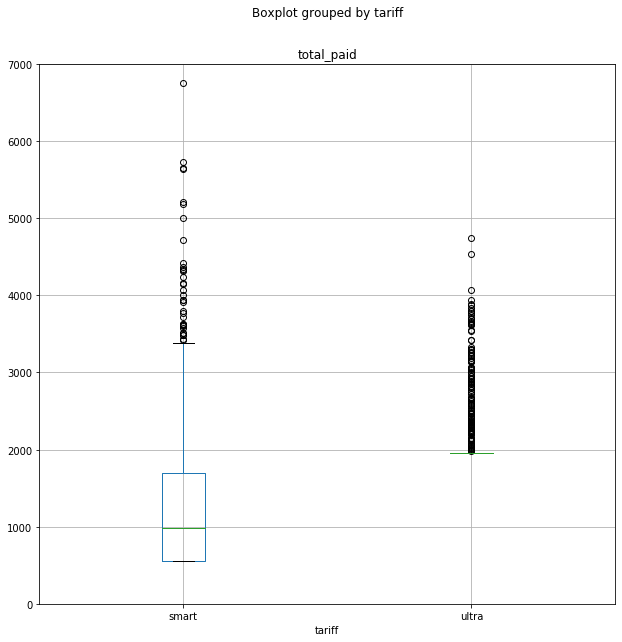

In [63]:
df.boxplot('total_paid', by='tariff', figsize=(10,10)).set_ylim(0,7000)

Отсюда немного не понятно что творится с тарифом Ультра. Необходимо попробовать пйоти другим путем и составить гистограммы по каждой категории в обоих тарифах.

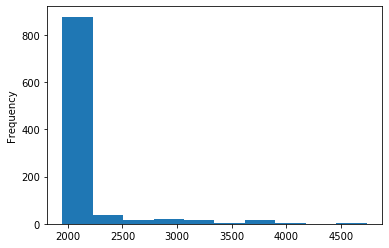

In [64]:
df[df['tariff'] == 'ultra']['total_paid'].plot(kind='hist', bins=10)

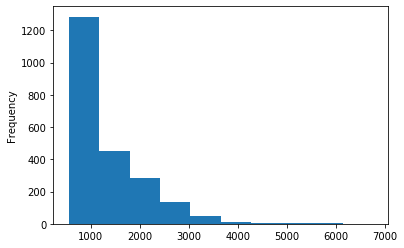

In [65]:
df[df['tariff'] == 'smart']['total_paid'].plot(kind='hist', bins=10)

In [66]:
df.groupby('tariff')\
  .agg({'total_paid':['median','mean','var','std']})\
  .style.format("{:.2f}")

Как видно, в тарифе Ультра люди редко вылезают за рамки своей месячной оплаты, чего не скажешь о тарифе Смарт. В нём это похоже на обыденность

In [67]:
df.groupby('tariff')\
  .agg({'month_calls_duration':['median','mean','var','std']})\
  .style.format("{:.2f}")

Text(0.5, 1.0, 'Смарт — Звонки в минутах в месяц')

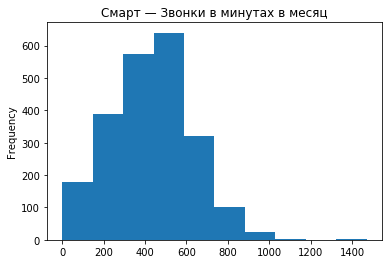

In [68]:
df[df['tariff'] == 'smart']['month_calls_duration'].plot(kind='hist', bins=10)
plt.title('Смарт — Звонки в минутах в месяц')

Text(0.5, 1.0, 'Ультра — Звонки в минутах в месяц')

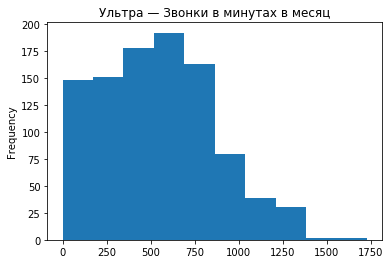

In [69]:
df[df['tariff'] == 'ultra']['month_calls_duration'].plot(kind='hist', bins=10)
plt.title('Ультра — Звонки в минутах в месяц')

На Смарте люди в месяц говорят около 450 минут, на Ультре 550 минут в месяц. То есть на Смарте люди подходят к краю своего тарифа, а на Ультре у них остается запас 2500 минут. Среднее и медиана лежат рядом в обоих тарифах

In [70]:
df.groupby('tariff')\
  .agg({'mb_total_in_month':['median','mean','var','std']})\
  .style.format("{:.2f}")

Text(0.5, 1.0, 'Смарт — Интернет в МБ в месяц')

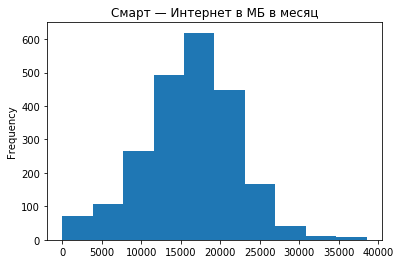

In [71]:
df[df['tariff'] == 'smart']['mb_total_in_month'].plot(kind='hist', bins=10)
plt.title('Смарт — Интернет в МБ в месяц')

Text(0.5, 1.0, 'Ультра — Интернет в МБ в месяц')

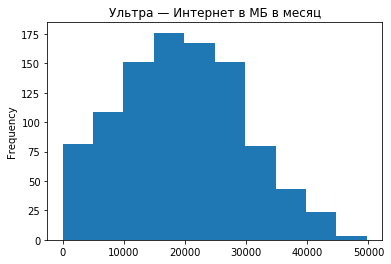

In [72]:
df[df['tariff'] == 'ultra']['mb_total_in_month'].plot(kind='hist', bins=10)
plt.title('Ультра — Интернет в МБ в месяц')

Среднее и медиана лежат рядом в обоих тарифах, так же как и в звонках. На Смарте люди выходят за пределы тарифа больше, у Ультры снова запас в 10 Гб

In [73]:
df.groupby('tariff')\
  .agg({'sms_total_in_month':['median','mean','var','std']})\
  .style.format("{:.2f}")

Text(0.5, 1.0, 'Смарт — СМС в месяц')

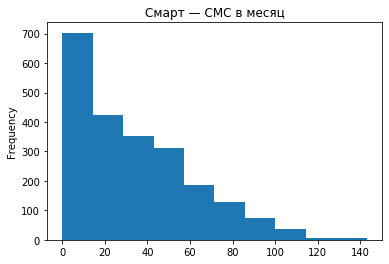

In [74]:
df[df['tariff'] == 'smart']['sms_total_in_month'].plot(kind='hist', bins=10)
plt.title('Смарт — СМС в месяц')

Text(0.5, 1.0, 'Ультра — СМС в месяц')

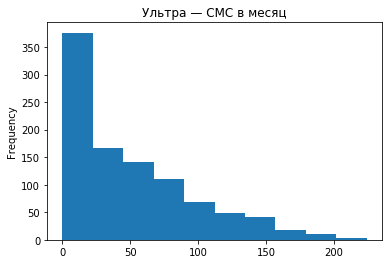

In [75]:
df[df['tariff'] == 'ultra']['sms_total_in_month'].plot(kind='hist', bins=10)
plt.title('Ультра — СМС в месяц')

Сначала показалось что где-то ошибка в данных. Но нет, по смскам всё очень похоже в каждом тарифе

## Шаг 4. Проверка гипотез

 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Функция для удаления выбросов:

In [76]:
def delete_outliers(df, column, graphic=0, x = 10, y = 10):
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    iqr_test = (df[column] >= (q1 - 1.5 * iqr)) & (df[column] <= (q3 + 1.5 * iqr))
    if graphic == 1:
        return df.loc[iqr_test].boxplot([column], figsize=(x,y))
    else:
        return df.loc[iqr_test]

По-скольку сравниваемы выборки независимы между собой - будет использоваться t-критерий Стьюдента

Гипотеза о равенстве средних двух генеральных совокупностей №1:

 - H0: выручка пользователей тарифов «Ультра» и «Смарт» не различается
 - H1: выручка пользователей тарифов «Ультра» и «Смарт» различается

In [77]:
df.head()

,user_id,month,month_calls_duration,calls_total_in_month,sms_total_in_month,mb_total_in_month,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,above_the_tariff,total_paid
0,1000,August,418.0,52.0,81.0,14055.93,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
1,1000,December,341.0,46.0,70.0,9817.61,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
2,1000,July,346.0,47.0,75.0,14003.64,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
3,1000,June,187.0,43.0,60.0,23233.77,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0
4,1000,May,164.0,22.0,22.0,2253.49,52,NaT,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,0.0,1950.0


In [78]:
ultra = df[df['tariff'] == 'ultra']
smart = df[df['tariff'] == 'smart']

In [79]:
ultra = delete_outliers(ultra, 'total_paid', 0)
ultra = ultra['total_paid']

In [80]:
smart = delete_outliers(smart, 'total_paid', 0)
smart = smart['total_paid']

In [81]:
alpha = 0.05

In [82]:
results = st.ttest_ind(ultra, smart)

In [83]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.3182106890742663e-188
Отвергаем нулевую гипотезу


Есть значимые различия между выборками, отсюда такой результат

Гипотеза о равенстве средних двух генеральных совокупностей №2:
 - H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов
 - H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [84]:
df['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Курган', 'Барнаул', 'Красноярск', 'Архангельск', 'Липецк',
       'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Волжский', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [85]:
df['region'] = np.where(df['city'] == 'Москва', 'Москва', 'Провинция')

In [86]:
moscow = df[df['region'] == 'Москва']
province = df[df['region'] == 'Провинция']

In [87]:
moscow = delete_outliers(moscow, 'total_paid', 0)
moscow = moscow['total_paid']

In [88]:
province = delete_outliers(province, 'total_paid', 0)
province = province['total_paid']

In [89]:
results = st.ttest_ind(moscow, province)

In [90]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.3093579795626914
Не получилось отвергнуть нулевую гипотезу


С вероятностью почти 31% такой результат мог быть получен случайно. Можно сделать вывод что значимых различий между выборками нет

## Шаг 5. Общий вывод

Люди на разных тарифах ведут себя по-разному, переплачивают и там и там, но особенно это видно на Смарте. Очевидно что на Смарте ищут выгоды, а на Ультре не хотят переживать за доплаты и переплаты. Возможно компании нужно искать как улучшить Смарт чтобы текущие условия тарифа не приводили к оттоку клиентов.

СМС-ки никому не нужны на обоих тарифах. Но если в Смарте люди близки к своим лимитам, то на Ультре остаются большие неизрасходованные "запасы" — возможно, имеет смысл подумать, как использовать эту, по сути, упущенную выгоду

Деньги одинаково текут и из регионов и из Москвы, и вероятно это не связано с уровнем жизни, а с поведением: ~8-10 часов в месяц — это предел у среднего клиента на обоих тарифах

Тарифы приносят разные деньги, значимые различия есть